# [LAB 06] 지도학습 > 예측 > 선형 > 08.다항회귀
- 피쳐들 (독립변수) 와 레이블 (종속변수) 이 2차 함수 이상의 관계를 가지는 것으로 곡선이나 좀 더 복잡한 모양을 표현하는 것이 가능한 회귀 모형
- 단순히 독립변수를 제곱한 파생변수를 추가하고, 다중 선형회귀를 적용한다

## #01. 준비작업
### [1] 패키지 참조

In [27]:
from hossam import *
from pandas import DataFrame, read_excel
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
import statsmodels as sm

from itertools import combinations

#데이터 표준화 모듈
from sklearn.preprocessing import StandardScaler

#선형 회귀 분석 모듈
from sklearn.linear_model import LinearRegression

#훈련/검증 데이터 분리 모듈
from sklearn.model_selection import KFold,cross_val_predict,learning_curve,train_test_split,GridSearchCV

from scipy.stats import pearsonr,spearmanr

from sklearn.preprocessing import PolynomialFeatures,StandardScaler
#성능 평가 지표 모듈
from sklearn.metrics import(
  r2_score,
  mean_absolute_error,
  mean_squared_error,
  mean_absolute_percentage_error
)

from scipy.stats import shapiro,jarque_bera,t,f
from scipy.stats import t,f
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

import statsmodels.api as sm
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.graphics.gofplots import qqplot as sm_qqplot


### [2] 데이터 가져오기

In [2]:
origin = load_data('fish_processed')
origin.head()

농어의 길이,높이,두께,무게를 조사한 데이터의 전처리 버전


,길이,높이,두께,무게
0,-2.180225,-2.016507,-1.896175,1.931521
1,-1.587434,-1.518703,-1.560774,3.496508
2,-1.442032,-1.417039,-1.316328,3.713572
3,-1.307815,-1.147103,-1.202633,3.960813
4,-1.173599,-1.147103,-1.026405,4.262680


### [3] 산점도 행렬 확인
데이터의 분포가 곡선 형태임이 확인된다

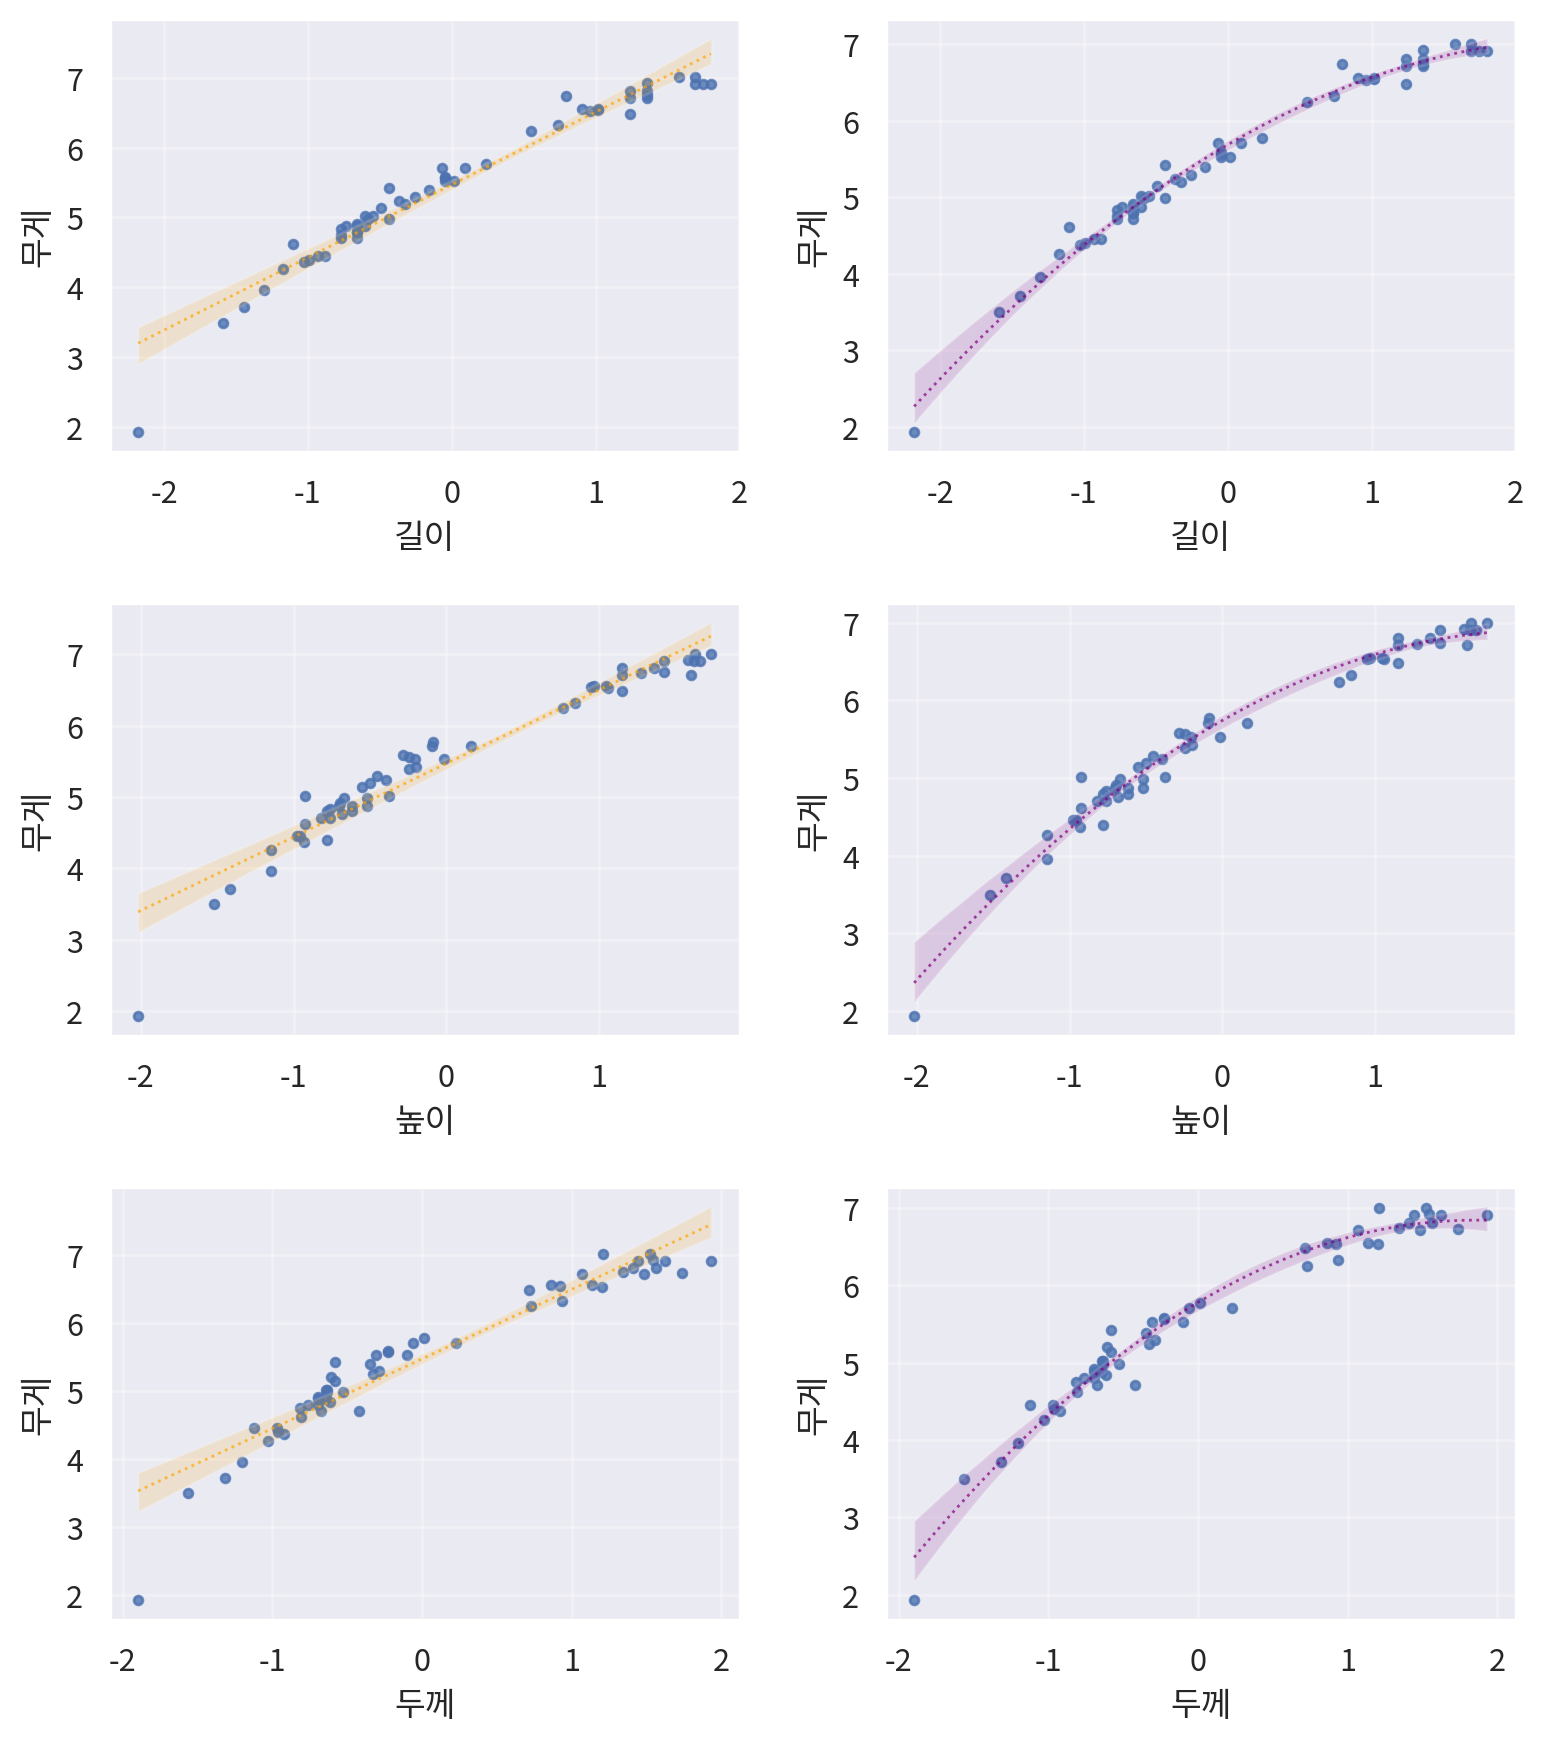

In [3]:
combo = ["길이", "높이", "두께"]
size = len(combo)

figsize = (1600 / my_dpi, 600 * size / my_dpi)
fig, ax = plt.subplots(size, 2, figsize=figsize, dpi=my_dpi)

for s in range(size):
    sb.regplot(
        data=origin,
        x=combo[s],
        y="무게",
        scatter_kws={"s": 10},
        line_kws={"color": "orange", "linewidth": 1, "alpha": 0.7, "linestyle": ":"},
        ax=ax[s][0],
    )
    ax[s][0].grid(True, alpha=0.3)

    sb.regplot(
        data=origin,
        x=combo[s],
        y="무게",
        order=2,
        scatter_kws={"s": 10},
        line_kws={"color": "purple", "linewidth": 1, "alpha": 0.7, "linestyle": ":"},
        ax=ax[s][1],
    )
    ax[s][1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()


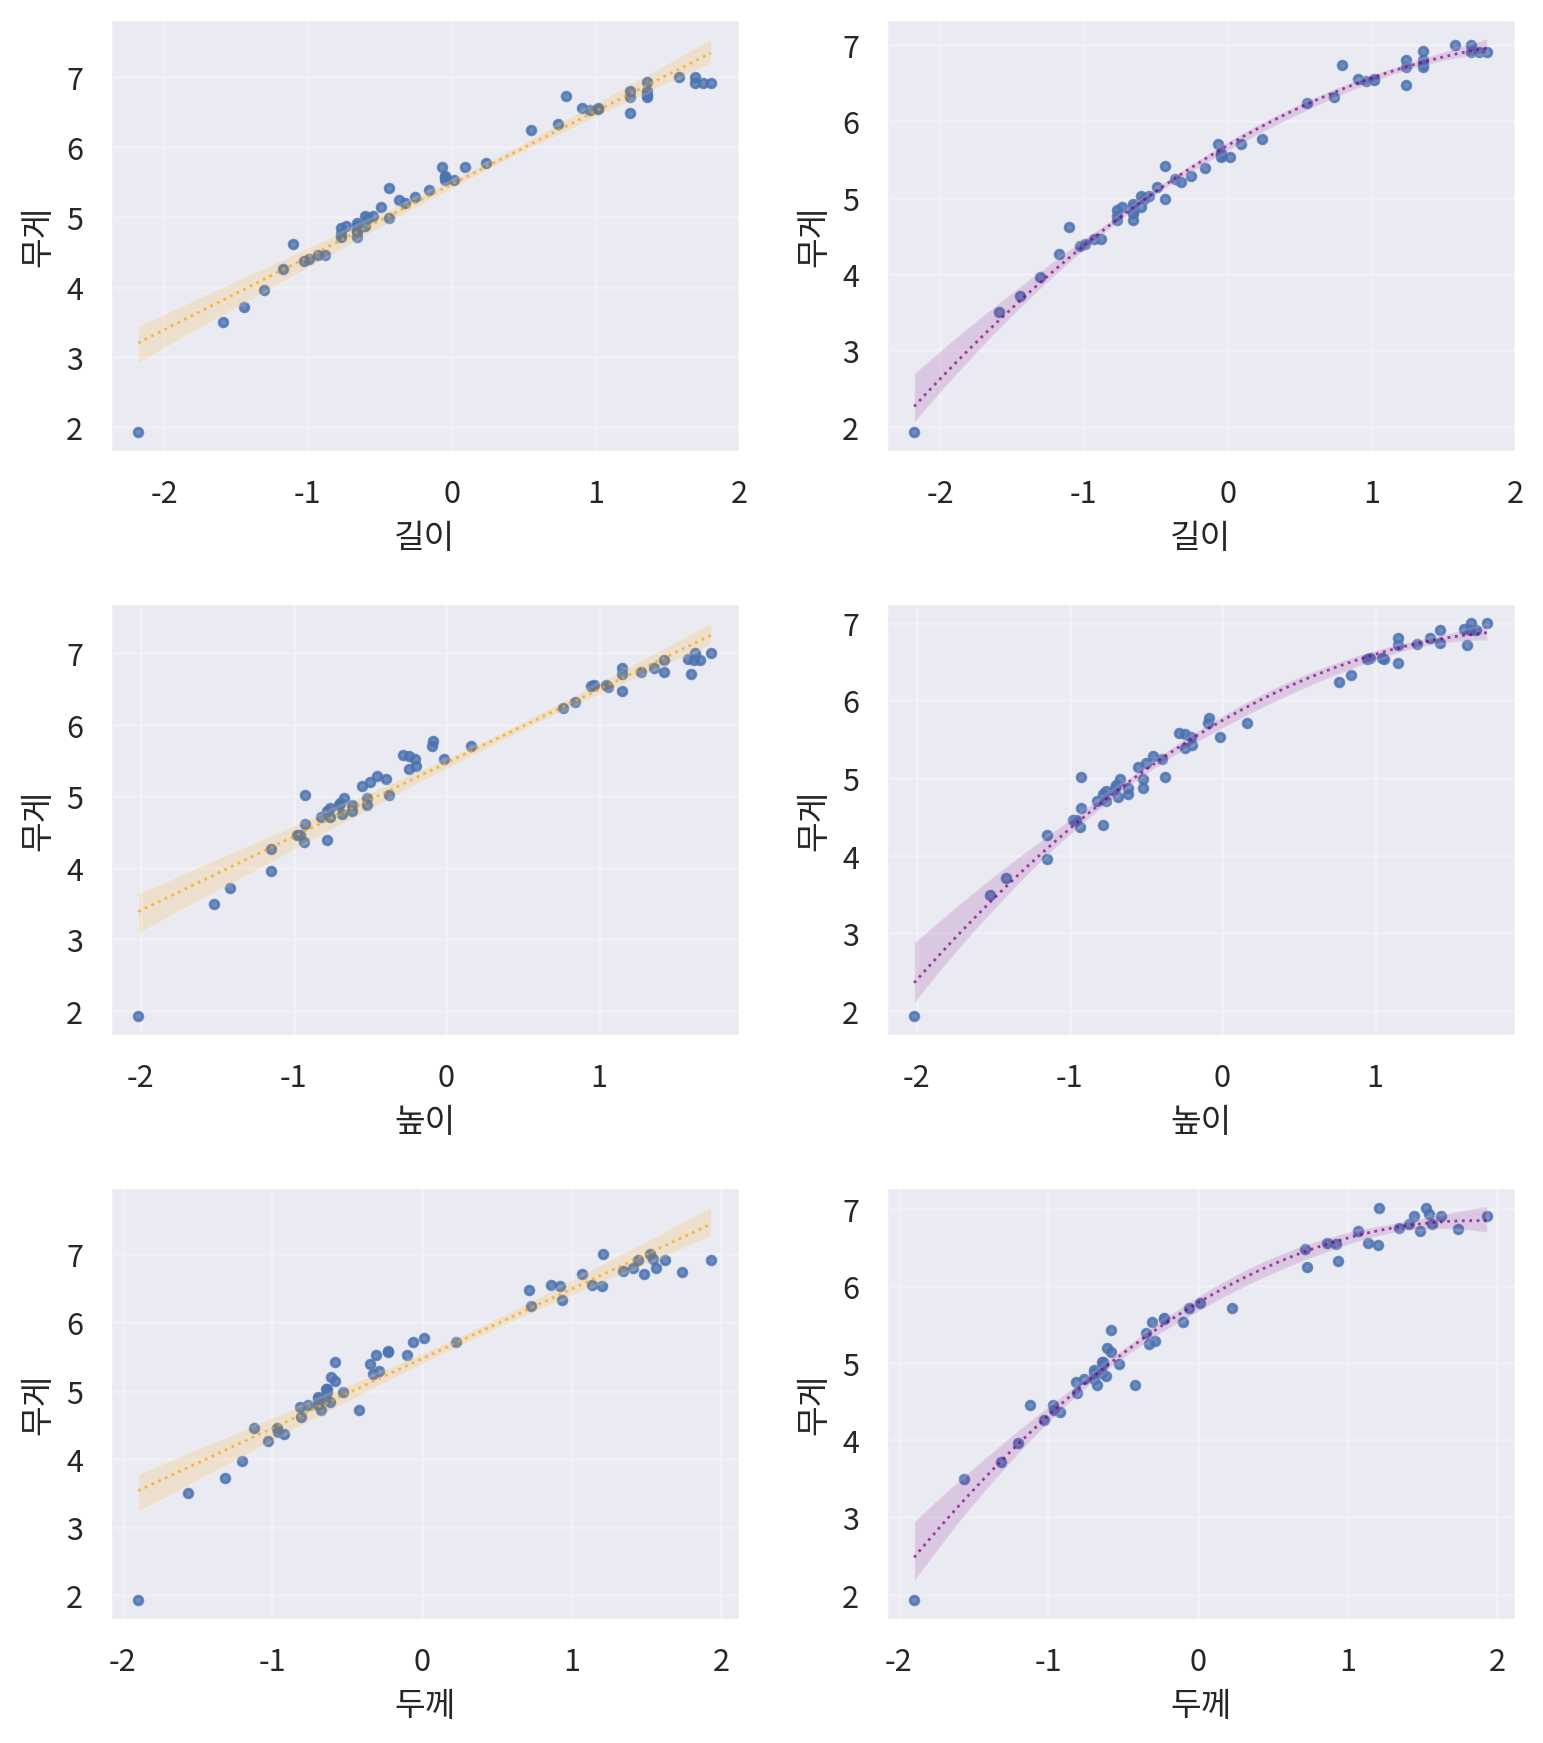

In [4]:
combo = ["길이", "높이", "두께"]
size = len(combo)

figsize = (1600 / my_dpi, 600 * size / my_dpi)
fig, ax = plt.subplots(size, 2, figsize=figsize, dpi=my_dpi)

for s in range(size):
    sb.regplot(
        data=origin,
        x=combo[s],
        y="무게",
        scatter_kws={"s": 10},
        line_kws={"color": "orange", "linewidth": 1, "alpha": 0.7, "linestyle": ":"},
        ax=ax[s][0],
    )
    ax[s][0].grid(True, alpha=0.3)

    sb.regplot(
        data=origin,
        x=combo[s],
        y="무게",
        order=2,
        scatter_kws={"s": 10},
        line_kws={"color": "purple", "linewidth": 1, "alpha": 0.7, "linestyle": ":"},
        ax=ax[s][1],
    )
    ax[s][1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()


> 2차 곡선이 더 자연스러워 보임

## #02.데이터 전처리 - 2차항 생성하기
### [1] 방법 1 - 직접 생성하기
#### (1) 모든 독립변수에 대해 제곱한 파생변수를 생성한다

In [6]:
df1 = origin.drop('무게',axis=1).copy()
columns = df1.select_dtypes(include=np.number).columns

for col in columns:
  df1[f'{col}^2'] = df1[col] **2


df1.head()

,길이,높이,두께,길이^2,높이^2,두께^2
0,-2.180225,-2.016507,-1.896175,4.753381,4.066302,3.595479
1,-1.587434,-1.518703,-1.560774,2.519946,2.306460,2.436014
2,-1.442032,-1.417039,-1.316328,2.079457,2.008000,1.732721
3,-1.307815,-1.147103,-1.202633,1.710381,1.315845,1.446326
4,-1.173599,-1.147103,-1.026405,1.377334,1.315845,1.053508


#### (2) 변수가 2개 이상인 경우 2개씩 조합 가능한 모든 쌍에 대해 곱한 변수를 생성한다

In [7]:
#columns 의 변수에 대해 2개씩 조합한 곱셈항 추가

for col1,col2 in combinations(columns,2):
  df1[f'{col1}*{col2}'] = df1[col1] * df1[col2]


df1.head()

,길이,높이,두께,길이^2,높이^2,두께^2,길이*높이,길이*두께,높이*두께
0,-2.180225,-2.016507,-1.896175,4.753381,4.066302,3.595479,4.396440,4.134088,3.823651
1,-1.587434,-1.518703,-1.560774,2.519946,2.306460,2.436014,2.410841,2.477625,2.370352
2,-1.442032,-1.417039,-1.316328,2.079457,2.008000,1.732721,2.043416,1.898188,1.865289
3,-1.307815,-1.147103,-1.202633,1.710381,1.315845,1.446326,1.500199,1.572822,1.379544
4,-1.173599,-1.147103,-1.026405,1.377334,1.315845,1.053508,1.346238,1.204588,1.177393


#### (3) 종속변수 추가

In [8]:
df1['무게'] = origin['무게']
df1.head()

,길이,높이,두께,길이^2,높이^2,두께^2,길이*높이,길이*두께,높이*두께,무게
0,-2.180225,-2.016507,-1.896175,4.753381,4.066302,3.595479,4.396440,4.134088,3.823651,1.931521
1,-1.587434,-1.518703,-1.560774,2.519946,2.306460,2.436014,2.410841,2.477625,2.370352,3.496508
2,-1.442032,-1.417039,-1.316328,2.079457,2.008000,1.732721,2.043416,1.898188,1.865289,3.713572
3,-1.307815,-1.147103,-1.202633,1.710381,1.315845,1.446326,1.500199,1.572822,1.379544,3.960813
4,-1.173599,-1.147103,-1.026405,1.377334,1.315845,1.053508,1.346238,1.204588,1.177393,4.262680


### [2] 방법 2 - sklearn 의 전처리 기능 활용
PolynomiaFeatures 클래스를 사용하여 y=ax+b 라는 회귀식을 y=ax2 + bx + c 형태로 바꾼다

#### (1) 2차항에 대한 변수값 생성
|파라미터|설명|
|-|-|
|degree|변환할 차수(기본값=2)|
|include_bias|True 인 경우 0차항도 함꼐 생성 (기본값 True)|

In [11]:
poly=PolynomialFeatures(degree=2,include_bias=False)
poly_fit = poly.fit_transform(origin[['길이','높이','두께']])
poly_fit[:3]

array([[-2.18022506, -2.0165074 , -1.89617489,  4.75338133,  4.39643997,
         4.13408802,  4.06630209,  3.8236507 ,  3.59547922],
       [-1.58743393, -1.51870326, -1.56077354,  2.51994649,  2.41084109,
         2.47762488,  2.3064596 ,  2.37035187,  2.43601404],
       [-1.44203233, -1.41703904, -1.31632849,  2.07945725,  2.04341611,
         1.89818824,  2.00799964,  1.86528885,  1.73272069]])

#### (2) 각 변수별로 Feature 의 이름 확인

In [12]:
poly.get_feature_names_out()

array(['길이', '높이', '두께', '길이^2', '길이 높이', '길이 두께', '높이^2', '높이 두께',
       '두께^2'], dtype=object)

#### (3) 데이터 프레임으로 재구성

In [13]:
df2 = DataFrame(poly_fit,columns=poly.get_feature_names_out())

#종속변수 복사
df2['무게'] = origin['무게']
df2.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게
0,-2.180225,-2.016507,-1.896175,4.753381,4.396440,4.134088,4.066302,3.823651,3.595479,1.931521
1,-1.587434,-1.518703,-1.560774,2.519946,2.410841,2.477625,2.306460,2.370352,2.436014,3.496508
2,-1.442032,-1.417039,-1.316328,2.079457,2.043416,1.898188,2.008000,1.865289,1.732721,3.713572
3,-1.307815,-1.147103,-1.202633,1.710381,1.500199,1.572822,1.315845,1.379544,1.446326,3.960813
4,-1.173599,-1.147103,-1.026405,1.377334,1.346238,1.204588,1.315845,1.177393,1.053508,4.262680


### [3] 2차항이 추가된 데이터의 분포 확인
#### (1) 독립변수의 데이터 분포
 - 스케일링의 필요 여부를 확인하기 위한 시각화 이므로 종속변수는 포함할 필요 없음

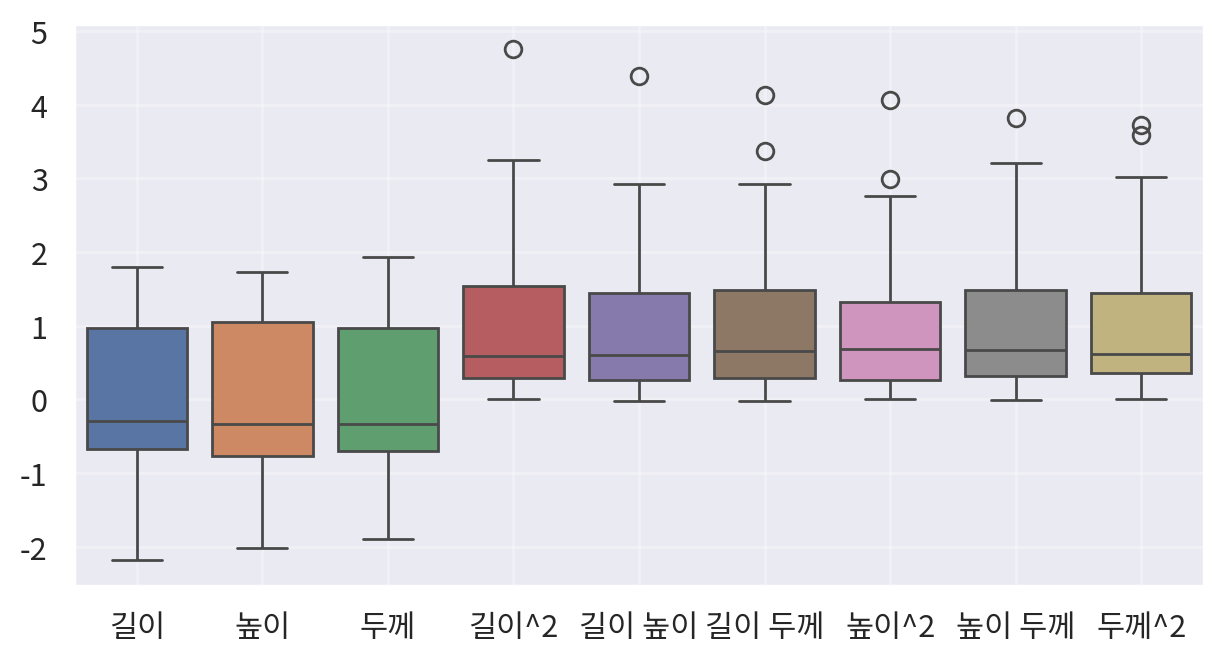

In [14]:
figsize = (1280 / my_dpi, 720 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.boxplot(data=df2.drop("무게", axis=1), ax=ax)

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()


#### 제곱항에 대한 스케일 폭발 문제
- 2차항은 값의 범위가 제곱만큼 커지기 떄문에 계수 추정이 2차항에 과도하게 끌릴 위험 있음
- 서로 다른 스케일의 변수 공존시
- 조건수 증가, 최적화 수렴 불안정
- 2차항은 새로운 변수이므로, 원본 변수와 동일하게 스케일링 대상임

#### (2) 데이터 스케일링

In [15]:
df = df2.drop("무게", axis=1)
scaler = StandardScaler()

df3 = DataFrame(scaler.fit_transform(df), columns=df.columns)
df3["무게"] = df2["무게"]

df3.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게
0,-2.180225,-2.016507,-1.896175,3.708586,3.556234,3.381553,3.290051,3.122527,2.755507,1.931521
1,-1.587434,-1.518703,-1.560774,1.501806,1.485983,1.608680,1.401792,1.525106,1.524553,3.496508
2,-1.442032,-1.417039,-1.316328,1.066574,1.102893,0.988523,1.081554,0.969957,0.777897,3.713572
3,-1.307815,-1.147103,-1.202633,0.701903,0.536517,0.640291,0.338893,0.436042,0.473845,3.960813
4,-1.173599,-1.147103,-1.026405,0.372830,0.375993,0.246179,0.338893,0.213843,0.056807,4.262680


#### (3) 스케일링 결과 확인

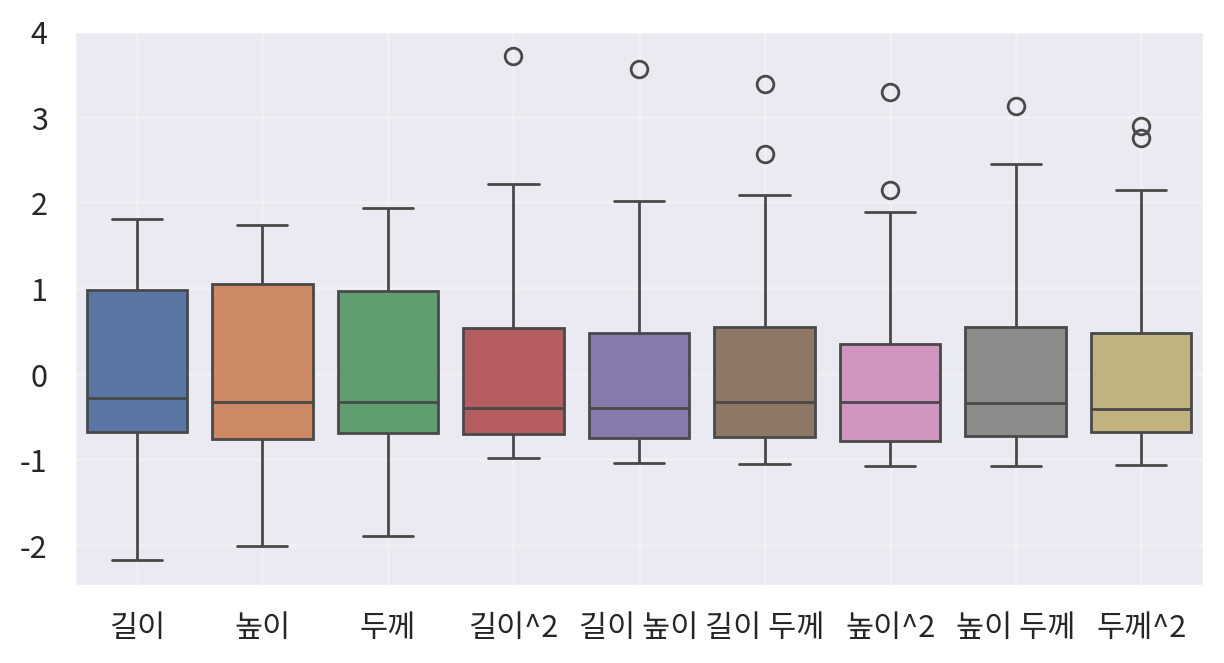

In [16]:
figsize = (1280 / my_dpi, 720 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.boxplot(data=df3.drop("무게", axis=1), ax=ax)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()


#### (4) 전처리 결과 저장

In [17]:
df3.to_excel('fish_poly_scaled.xlsx',index=False)

### [4] 훈련/검증 데이터 분리

In [18]:
df = df3

yname = "무게"

x = df.drop(columns=[yname])
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=52
)

x_train.shape, x_test.shape, y_train.shape, y_test.shape


((42, 9), (14, 9), (42,), (14,))

## #03.회귀모델 적합

### [1] 모델 구축

In [19]:
estimator = LinearRegression(n_jobs=-1)
estimator.fit(x_train,y_train)
estimator

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",-1
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


### [2] 예측 성능 확인
- 아래 표는 다중 선형 회귀의 성능 평가 표

| 성능지표 | R2    | MAE   | MSE   | RMSE  | MAPE  | MPE   |
| ---- | ----- | ----- | ----- | ----- | ----- | ----- |
| 값    | 0.952 | 0.176 | 0.056 | 0.236 | 0.030 | 0.744 |


In [20]:
y_pred = estimator.predict(x_test)

result_df = DataFrame(
    {
        "결정계수(R2)": r2_score(y_test, y_pred),
        "평균절대오차(MAE)": mean_absolute_error(y_test, y_pred),
        "평균제곱오차(MSE)": mean_squared_error(y_test, y_pred),
        "평균오차(RMSE)": np.sqrt(mean_squared_error(y_test, y_pred)),
        "평균 절대 백분오차(MAPE)": mean_absolute_percentage_error(y_test, y_pred),
        "평균 비율 오차(MPE)": np.mean((y_test - y_pred) / y_test * 100),
    },
    index=["성능지표"],
)

result_df


,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차(MAPE),평균 비율 오차(MPE)
성능지표,0.953864,0.137807,0.053552,0.231413,0.022988,1.509018


#### 인사이트

좋아, 마크다운에 바로 붙여넣기 가능하게 정리해줄게 ✨

---
## 💡 인사이트
### 📊 전반적 성능 비교
* **다항회귀 모델이 모든 성능 지표에서 다중회귀 모델보다 더 우수함**을 확인할 수 있음.

---

### 📈 결정계수 (R²)
* 다항회귀: **0.954**
* 다중회귀: **0.952**
  → 다항회귀가 약간 더 높은 설명력을 가짐.

---
### 📉 오차 지표 (MAE, MSE, RMSE)
* **MAE (평균절대오차)**
  * 다항회귀 **0.138** < 다중회귀 **0.176**
* **MSE (평균제곱오차)**
  * 다항회귀 **0.054** < 다중회귀 **0.056**
* **RMSE (평균오차)**
  * 다항회귀 **0.231** < 다중회귀 **0.236**

→ 모든 오차 지표에서 **다항회귀가 더 낮은 값**을 보여 예측 오차가 더 적음.
---
### 📊 비율 오차 (MAPE, MPE)
* **MAPE (평균 절대 백분오차 비율)**
  * 다항회귀 **0.023** < 다중회귀 **0.030**
* **MPE (평균 비율 오차)**
  * 다항회귀 **1.509** > 다중회귀 **0.744**

→ MAPE 기준으로는 **다항회귀가 더 우수**함.
→ 다만 MPE는 다항회귀가 더 크지만, **절대값 기준으로 두 모델 모두 1% 내외로 매우 작음**.

---

### 🏆 모델 선택

* 전반적으로 **다항회귀 모델이 더 높은 설명력과 더 낮은 예측 오차**를 보임.
* 따라서, **현재 데이터와 문제 상황에서는 다항회귀 모델을 채택하는 것이 더 적합**함.


## #04.과적합 판정

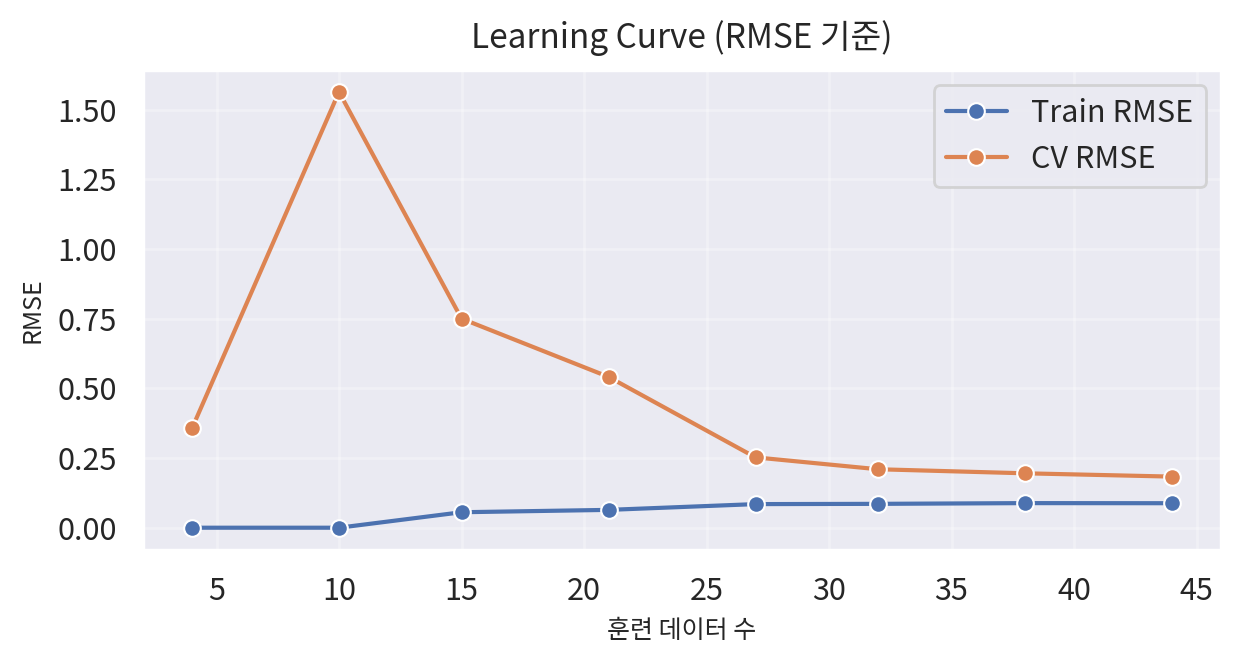

,지표,값
0,Train RMSE,0.087883
1,CV RMSE 평균,0.183345
2,CV RMSE 표준편차,0.075449
3,Train/CV 비율,0.479333
4,CV 변동성 비율,0.411515
5,판정 결과,⚠️ 과대적합 (일반화 실패)


In [21]:

# 반드시 원본 전체 데이터 적용
train_sizes, train_scores, cv_scores = learning_curve(
    estimator=estimator,
    X=x,
    y=y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 8),
    shuffle=True,
    random_state=52,
)

# neg RMSE → RMSE
train_rmse = -train_scores
cv_rmse = -cv_scores

# 평균 / 표준편차
train_mean = train_rmse.mean(axis=1)
cv_mean = cv_rmse.mean(axis=1)
cv_std = cv_rmse.std(axis=1)

# 마지막 지점 기준 정량 판단
final_train = train_mean[-1]
final_cv = cv_mean[-1]
final_std = cv_std[-1]

gap_ratio = final_train / final_cv
var_ratio = final_std / final_cv

# 판단 로직
if gap_ratio >= 1.2 and var_ratio <= 0.10:
    status = "⚠️ 과소적합 (모델이 너무 단순)"
elif gap_ratio <= 0.9 and var_ratio >= 0.20:
    status = "⚠️ 과대적합 (일반화 실패)"
elif gap_ratio <= 0.9 and var_ratio <= 0.10:
    status = "✅ 일반화 양호"
elif gap_ratio >= 0.9 and var_ratio > 0.10:
    status = "⚠️ 데이터 부족 (표본 수 문제)"
else:
    status = "⚠️ 판단 유보"

# 시각화 (Learning Curve)
figsize = (1280 / my_dpi, 720 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.lineplot(
    x=train_sizes,
    y=train_mean,
    marker="o",
    label="Train RMSE",
    ax=ax,
)

sb.lineplot(
    x=train_sizes,
    y=cv_mean,
    marker="o",
    label="CV RMSE",
    ax=ax,
)

ax.set_title("Learning Curve (RMSE 기준)", fontsize=12, pad=8)
ax.set_xlabel("훈련 데이터 수", fontsize=9)
ax.set_ylabel("RMSE", fontsize=9)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()
plt.close()

# 정량 결과 표
result_df = DataFrame(
    {
        "지표": [
            "Train RMSE",
            "CV RMSE 평균",
            "CV RMSE 표준편차",
            "Train/CV 비율",
            "CV 변동성 비율",
            "판정 결과",
        ],
        "값": [
            final_train,
            final_cv,
            final_std,
            gap_ratio,
            var_ratio,
            status,
        ],
    }
)

result_df

✏️ 인사이트

⚠️ 현재 다항회귀 모델은 과대적합(일반화 실패)으로 판정됨.
훈련 데이터에서는 매우 낮은 RMSE(0.088)로 우수한 성능을 보이지만, 교차검증(CV) RMSE 평균(0.183)이 훈련 대비 2배 이상 높음

Train/CV 비율(0.479)과 CV 변동성 비율(0.415)도 과대적합의 전형적 패턴을 보임

❗ 과대적합 모델의 독립변수 해석은 신뢰할 수 없음
모델이 훈련 데이터에만 특화되어, 실제 중요한 변수를 과대평가하거나 불필요한 변수에 과도하게 의존할 수 있음
일반화되지 않은 계수 및 변수 중요도는 현업 적용이나 보고에 부적합

🚫 따라서, 과대적합이 명확히 판정된 모델의
독립변수(계수, 중요도 등) 결과를 공식적으로 보고하는 것은 권장하지 않음
모델 단순화, 정규화, 데이터 확장 등 추가 조치 후
일반화 성능이 확보된 모델에서 해석 및 보고를 진행하는 것이 바람직

📌 이 데이터는 처음부터 과적합 개념 설명을 위해 의도적으로 생성한 가상 데이터이므로
지금 결과는 무시하고 다음 단계로 넘어가자!

## #05 가정 확인

### [1] 잔차 구하기

In [22]:
rdf = x_train.copy()
rdf[yname] = y_train


#예측치
rdf['y_pred'] = estimator.predict(x_train)


#잔차
rdf['resid'] = rdf[yname] - rdf['y_pred']

rdf.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게,y_pred,resid
19,-0.603177,-0.701884,-0.639841,-0.628585,-0.586230,-0.630003,-0.544381,-0.586680,-0.627018,4.875197,4.908031,-0.032834
37,0.548851,0.759978,0.724503,-0.690423,-0.592742,-0.617473,-0.453259,-0.475101,-0.504387,6.244167,6.306256,-0.062089
40,0.962686,1.057959,1.202024,-0.072361,0.034264,0.195431,0.127981,0.317494,0.472290,6.530878,6.551430,-0.020553
6,-1.028197,-0.933258,-0.924079,0.056507,-0.027158,-0.026155,-0.138446,-0.132382,-0.155084,4.369448,4.366845,0.002603
24,-0.435406,-0.200574,-0.582993,-0.800750,-0.936585,-0.771385,-1.029805,-0.951781,-0.700819,5.420535,5.291679,0.128856


### [2] 선형성

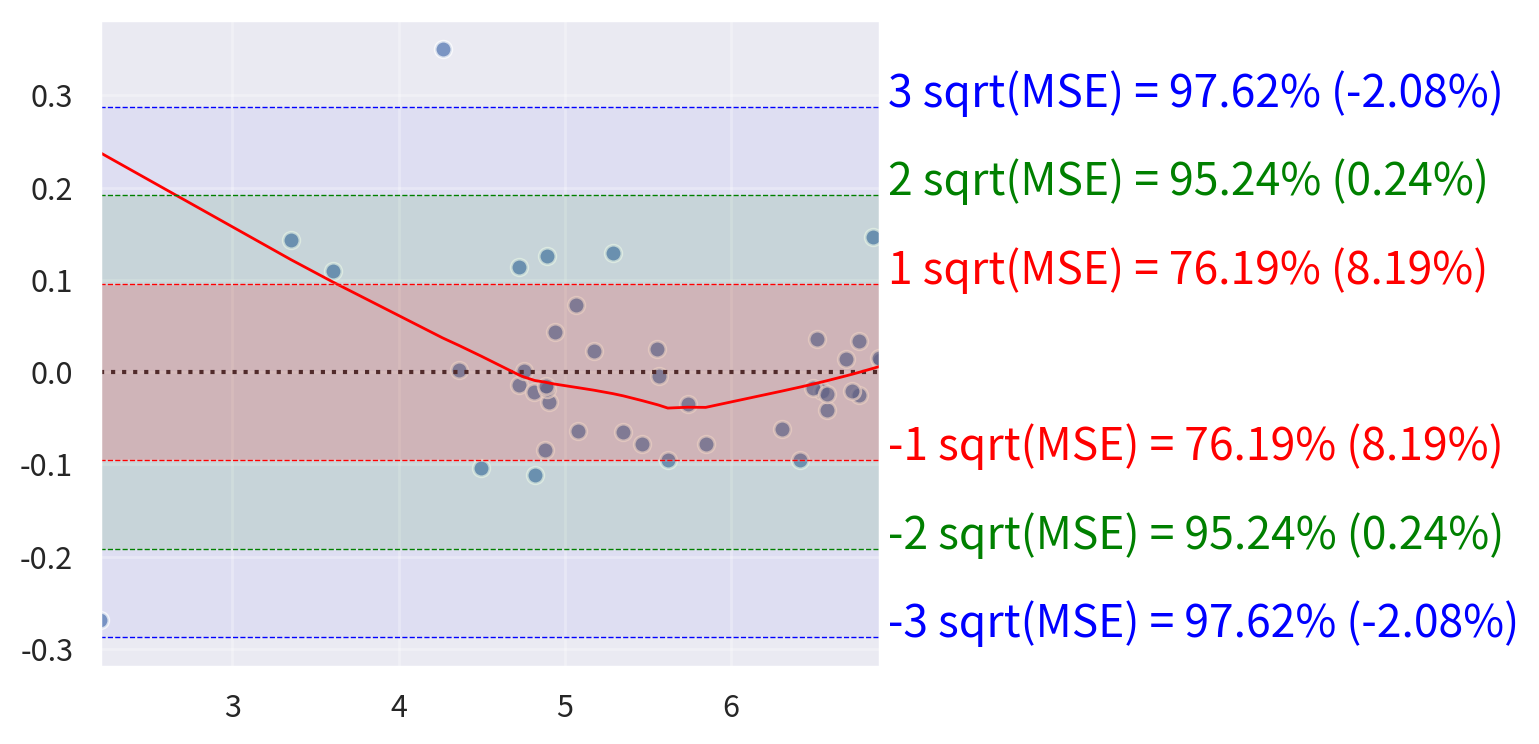

In [23]:
y = rdf[yname].values
y_pred = rdf["y_pred"].values
resid = rdf["resid"].values

figsize = (1600 / my_dpi, 800 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

# 잔차 산점도
sb.residplot(
    x=y_pred,
    y=resid,
    lowess=True,  # 잔차의 추세선 표시
    line_kws={"color": "red", "linewidth": 1},  # 추세선 스타일
    scatter_kws={"edgecolor": "white", "alpha": 0.7},
)

# MSE표시
mse_val = mean_squared_error(y, y_pred)
mse_sq = np.sqrt(mse_val)

r1 = resid[(resid > -mse_sq) & (resid < mse_sq)].size / resid.size * 100
r2 = resid[(resid > -2 * mse_sq) & (resid < 2 * mse_sq)].size / resid.size * 100
r3 = resid[(resid > -3 * mse_sq) & (resid < 3 * mse_sq)].size / resid.size * 100

mse_r = [r1, r2, r3]
xmin, xmax = ax.get_xlim()

# 구간별 반투명 색상 채우기 (안쪽부터 바깥쪽으로, 진한 색에서 연한 색으로)
colors = ["red", "green", "blue"]
alphas = [0.15, 0.10, 0.05]  # 안쪽이 더 진하게

# 3σ 영역 (가장 바깥쪽, 가장 연함)
ax.axhspan(-3 * mse_sq, 3 * mse_sq, facecolor=colors[2], alpha=alphas[2], zorder=0)
# 2σ 영역 (중간)
ax.axhspan(-2 * mse_sq, 2 * mse_sq, facecolor=colors[1], alpha=alphas[1], zorder=1)
# 1σ 영역 (가장 안쪽, 가장 진함)
ax.axhspan(-mse_sq, mse_sq, facecolor=colors[0], alpha=alphas[0], zorder=2)

# 경계선 그리기
for i, c in enumerate(["red", "green", "blue"]):
    ax.axhline(mse_sq * (i + 1), color=c, linestyle="--", linewidth=0.5)
    ax.axhline(mse_sq * (-(i + 1)), color=c, linestyle="--", linewidth=0.5)

target = [68, 95, 99.7]
for i, c in enumerate(["red", "green", "blue"]):
    ax.text(
        s=f"{i+1} sqrt(MSE) = {mse_r[i]:.2f}% ({mse_r[i] - target[i]:.2f}%)",
        x=xmax + 0.05,
        y=(i + 1) * mse_sq,
        color=c,
    )
    ax.text(
        s=f"-{i+1} sqrt(MSE) = {mse_r[i]:.2f}% ({mse_r[i] - target[i]:.2f}%)",
        x=xmax + 0.05,
        y=-(i + 1) * mse_sq,
        color=c,
    )

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()


#### 인사이트

- 잔차가 0을 중심으로 랜덤하게 분포하지 않고, 곡선 형태의 패턴(특히 왼쪽에서 감소, 오른쪽에서 증가하는 경향)이 뚜렷하게 나타남.

- 빨간 실선(잔차 추세선)이 직선이 아니라 곡선을 그리며, 특정 구간에서 체계적으로 양/음의 방향으로 벗어남.

- 이는 잔차의 선형성(선형성 가정)을 만족하지 못하는 전형적인 모습임.

- 추가적인 변수 변환, 모형 변경, 비선형성 보정 등이 필요함.

### [3] 정규성

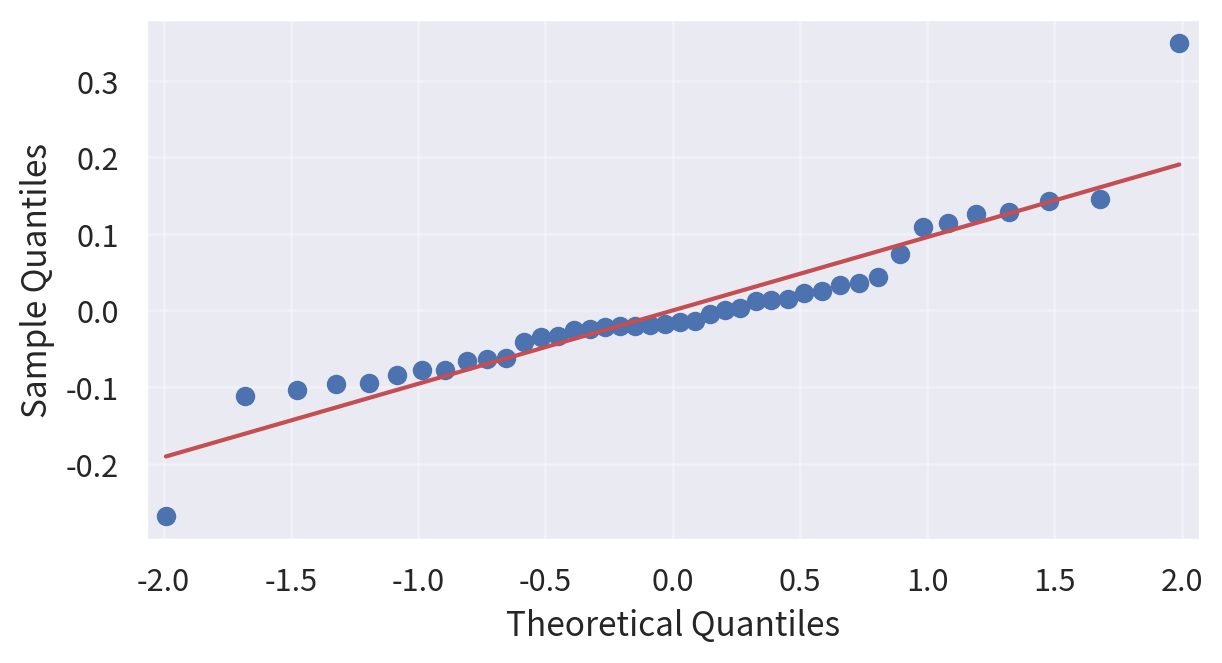

In [24]:
figsize = (1280 / my_dpi, 720 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

# statsmodels의 QQ plot 사용
sm_qqplot(rdf["resid"], line="s", ax=ax)

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()


In [28]:
residuals = rdf["resid"].values
n = len(residuals)
alpha = 0.05
results = []

# 1. Shapiro-Wilk 검정 (샘플 크기 < 5000일 때 권장)
if n < 5000:
    try:
        stat_sw, p_sw = shapiro(residuals)
        significant_sw = p_sw <= alpha

        if significant_sw:
            interpretation_sw = f"정규성 위반 (p={p_sw:.4f} <= {alpha})"
        else:
            interpretation_sw = f"정규성 만족 (p={p_sw:.4f} > {alpha})"

        results.append(
            {
                "검정": "Shapiro-Wilk",
                "검정통계량": f"{stat_sw:.4f}",
                "p-value": f"{p_sw:.4f}",
                "유의수준": alpha,
                "정규성_위반": significant_sw,
                "해석": interpretation_sw,
            }
        )
    except Exception as e:
        pass

# 2. Jarque-Bera 검정 (항상 수행)
try:
    stat_jb, p_jb = jarque_bera(residuals)
    significant_jb = p_jb <= alpha

    if significant_jb:
        interpretation_jb = f"정규성 위반 (p={p_jb:.4f} <= {alpha})"
    else:
        interpretation_jb = f"정규성 만족 (p={p_jb:.4f} > {alpha})"

    results.append(
        {
            "검정": "Jarque-Bera",
            "검정통계량": f"{stat_jb:.4f}",
            "p-value": f"{p_jb:.4f}",
            "유의수준": alpha,
            "정규성_위반": significant_jb,
            "해석": interpretation_jb,
        }
    )
except Exception as e:
    pass

result_df = DataFrame(results)
result_df


,검정,검정통계량,p-value,유의수준,정규성_위반,해석
0,Shapiro-Wilk,0.9086,0.0026,0.05,True,정규성 위반 (p=0.0026 <= 0.05)
1,Jarque-Bera,24.5382,0.0000,0.05,True,정규성 위반 (p=0.0000 <= 0.05)


### [4] 등분산성
- BP는 단순 이질분산만 보고, White 는 복잡한 이질분산까지 봄. 둘이 다르면 White 결과를 따름

In [29]:
resid = rdf["resid"]
alpha = 0.05

results = []

exog = rdf.drop(columns=[yname, "y_pred", "resid"])
exog = sm.add_constant(exog)

# 1. Breusch-Pagan 검정
try:
    lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(resid, exog)
    significant_bp = lm_pvalue <= alpha

    if significant_bp:
        interpretation_bp = f"등분산성 위반 (p={lm_pvalue:.4f} <= {alpha})"
    else:
        interpretation_bp = f"등분산성 만족 (p={lm_pvalue:.4f} > {alpha})"

    results.append(
        {
            "검정": "Breusch-Pagan",
            "검정통계량 (LM)": f"{lm:.4f}",
            "p-value": f"{lm_pvalue:.4f}",
            "유의수준": alpha,
            "등분산성_위반": significant_bp,
            "해석": interpretation_bp,
        }
    )
except Exception as e:
    pass

# 2. White 검정
try:
    lm, lm_pvalue, fvalue, f_pvalue = het_white(resid, exog)
    significant_white = lm_pvalue <= alpha

    if significant_white:
        interpretation_white = f"등분산성 위반 (p={lm_pvalue:.4f} <= {alpha})"
    else:
        interpretation_white = f"등분산성 만족 (p={lm_pvalue:.4f} > {alpha})"

    results.append(
        {
            "검정": "White",
            "검정통계량 (LM)": f"{lm:.4f}",
            "p-value": f"{lm_pvalue:.4f}",
            "유의수준": alpha,
            "등분산성_위반": significant_white,
            "해석": interpretation_white,
        }
    )
except Exception as e:
    pass

result_df = DataFrame(results)
result_df


,검정,검정통계량 (LM),p-value,유의수준,등분산성_위반,해석
0,Breusch-Pagan,24.0866,0.0042,0.05,True,등분산성 위반 (p=0.0042 <= 0.05)
1,White,41.9329,0.1647,0.05,False,등분산성 만족 (p=0.1647 > 0.05)


### [5] 독립성

In [30]:
# Durbin-Watson 통계량 계산
dw_stat = durbin_watson(rdf["resid"])

# 자기상관 판단 (1.5 < DW < 2.5 범위를 독립성 만족으로 판단)
is_autocorrelated = dw_stat < 1.5 or dw_stat > 2.5

# 해석 메시지 생성
if dw_stat < 1.5:
    interpretation = f"DW={dw_stat:.4f} < 1.5 (양의 자기상관)"
elif dw_stat > 2.5:
    interpretation = f"DW={dw_stat:.4f} > 2.5 (음의 자기상관)"
else:
    interpretation = f"DW={dw_stat:.4f} (독립성 가정 만족)"

# 결과 데이터프레임 생성
result_df = DataFrame(
    {
        "검정": ["Durbin-Watson"],
        "검정통계량(DW)": [dw_stat],
        "독립성_위반": [is_autocorrelated],
        "해석": [interpretation],
    }
)

result_df


,검정,검정통계량(DW),독립성_위반,해석
0,Durbin-Watson,2.141833,False,DW=2.1418 (독립성 가정 만족)


### [6] 가정에 위배되면?
- 가정 하나라도 위반되면 회귀를 버리는 것이 아니라, 모형을 보정하거나 적절한 대안을 선택하는 것이 올바른 대응임


| 위반 가정       | 문제 의미                        | 어떻게 확인하나?                 | 해결 방법                                                                      |
| ----------- | ---------------------------- | ------------------------- | -------------------------------------------------------------------------- |
| **선형성 위반**  | X와 Y의 관계가 직선이 아님             | 잔차 vs 적합값 그래프에서 곡선 패턴     | ① 변수 변환 (log, sqrt 등)<br>② 다항항 추가 (x² 등)<br>→ 선형회귀 안에서 해결 가능<br>③ 상호작용항 추가 |
| **정규성 위반**  | 잔차가 정규분포 아님 → p-value 신뢰도 감소 | QQ-plot / Shapiro-Wilk 검정 | ① Y 변환 (log, sqrt)<br>② 표본이 충분히 크면 (n > 30) 큰 문제 아님                        |
| **독립성 위반**  | 잔차가 서로 상관됨 (특히 시간 흐름 데이터)    | Durbin-Watson 통계량         | ① 추세·시간 변수 추가 (예: t)<br>② 시계열 모형으로 전환 필요                                   |
| **등분산성 위반** | 잔차 분산이 일정하지 않음 → 계수 해석 불안정   | 잔차 vs 적합값 그래프에서 “부채꼴 모양”  | ① Y 변환 (log, sqrt) → 가장 효과적<br>② 표본이 충분히 크면 (n > 30) 큰 문제 아님               |



## #06. 선형회귀 결과 보고
### [1] 모형 적합도

In [31]:
# 변수 이름 구하기
yname = "무게"
xnames = list(x_train.columns)

# 추정치
y_train_pred = estimator.predict(x_train)

# 잔차
resid = y_train - y_train_pred

# Durbin–Watson 통계량 계산
dw = durbin_watson(resid)

# 설명력
r2 = r2_score(y_train, y_train_pred)
r = np.sqrt(r2)
adj_r2 = 1 - (1 - r2) * (len(y_train) - 1) / (len(y_train) - len(xnames) - 1)

# 표본 수
rowcount = len(x_train)

# 독립변수 수
featurecount = len(xnames)

# F-statistic
f_statistic = (r2 / featurecount) / ((1 - r2) / (rowcount - featurecount - 1))

# Prob (F-statistic)
p = 1 - f.cdf(f_statistic, featurecount, rowcount - featurecount - 1)

# 모형 적합도 데이터프레임
rdf = DataFrame(
    {
        "R": [r],
        "R2": [r2],
        "Adj R2": [adj_r2],
        "F": [f_statistic],
        "p-value": [p],
        "Durbin-Watson": [dw],
    }
)

display(rdf)

# 결과 보고 문장
tpl = "R(%.3f), R2(%.3f), Adj R2(%.3f), F(%.3f), P-value(%.3f), Durbin-Watson(%.3f)"
print(tpl % (r, r2, adj_r2, f_statistic, p, dw))

tpl = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %.3f, p %s 0.05)."

print(
    tpl
    % (
        yname,
        ", ".join(xnames),
        "유의하다" if p <= 0.05 else "유의하지 않다",
        len(x_train.columns),
        len(x_train) - len(x_train.columns) - 1,
        f_statistic,
        "<=" if p <= 0.05 else ">",
    )
)


,R,R2,Adj R2,F,p-value,Durbin-Watson
0,0.995938,0.991893,0.989613,435.009706,1.110223e-16,2.141833


R(0.996), R2(0.992), Adj R2(0.990), F(435.010), P-value(0.000), Durbin-Watson(2.142)
무게에 대하여 길이, 높이, 두께, 길이^2, 길이 높이, 길이 두께, 높이^2, 높이 두께, 두께^2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(9,32) = 435.010, p <= 0.05).


### [2] 독립변수 보고

In [32]:
# 절편과 계수 결합
params = np.append(estimator.intercept_, estimator.coef_)

# 독립변수에 상수항 추가
design_x = x_train.copy()
design_x = sm.add_constant(design_x)

# 독립 변수 행렬곱
dot = np.dot(design_x.T, design_x)

# 역행렬
inv = np.linalg.inv(dot)

# 역행렬 대각선
dia = inv.diagonal()

# 평균 제곱 오차 (MSE)
predictions = estimator.predict(x_train)
n = design_x.shape[0]   # 샘플 수
p = design_x.shape[1]   # 변수 개수 (상수항 포함)
MSE = ((y_train - predictions) ** 2).sum() / (n - p)

# 표준오차
se_b = np.sqrt(MSE * dia)

# t-value
ts_b = params / se_b

# p-value
p_values = [2 * (1 - t.cdf(np.abs(i), n - p)) for i in ts_b]

# VIF 계산
vif = []
for i, v in enumerate(xnames):
    j = list(x_train.columns).index(v)
    vif.append(variance_inflation_factor(x_train.values, j))

# 표준화 계수(베타)
scaler = StandardScaler()
tmp_df = x_train.copy()
tmp_df[yname] = y_train

std = scaler.fit_transform(tmp_df)
std_df = DataFrame(std, columns=tmp_df.columns)

std_x = std_df.drop(columns=[yname])
std_y = std_df[yname]

s_estimator = LinearRegression(n_jobs=-1)
s_estimator.fit(std_x, std_y)
beta = s_estimator.coef_
